In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [25]:
from collections import Counter, defaultdict
from pathlib import Path
import pickle
from typing import Any

import datasets
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
import torch
import transformers

from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings
from src.utils.timit import load_or_prepare_timit_corpus

In [26]:
model_dir = "out/ce_model_phoneme_within_word_prefix_6_32"

# use a word-level equivalence dataset regardless of model, so that we can look up cohort facts
equiv_dataset_path = "data/timit_equiv_phoneme_within_word_prefix_6_1.pkl"
timit_corpus_path = "data/timit_phonemes"

In [27]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))

In [28]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset = pickle.load(f)

In [29]:
assert model.is_compatible_with(equiv_dataset)
assert all(type(label) == tuple for label in equiv_dataset.class_labels), "Assumes dataset with word prefix labels"

In [30]:
# Compute model representations on frame states.
model_representations = compute_embeddings(model, equiv_dataset,
                                           device="cpu")
model_representations = model_representations.numpy()

  0%|          | 0/4740 [00:00<?, ?it/s]

## Prepare cohort data

In [31]:
timit_corpus = datasets.load_from_disk(timit_corpus_path)

In [32]:
timit_word_tokens = {}
def process_item(item):
    words = item["word_detail"]["utterance"]
    phonemes = [[phone["phone"] for phone in word] for word in item["word_phonemic_detail"]]
    for word_string, phoneme_seq in zip(words, phonemes):
        timit_word_tokens[tuple(phoneme_seq)] = word_string
timit_corpus.map(process_item)
None

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [33]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)

In [34]:
timit_word_freqs = {}
for phoneme_seq, word in timit_word_tokens.items():
    try:
        freq = word_freq_df.loc[word, "Lg10WF"]
        timit_word_freqs[phoneme_seq] = freq
    except KeyError:
        timit_word_freqs[phoneme_seq] = 0

In [35]:
# TODO extract dictionary of full word forms from corpus or otherwise
cohorts: dict[tuple, Counter] = defaultdict(Counter)
for class_label in equiv_dataset.class_labels:
    compatible_words = [word for word in timit_word_freqs if word[:len(class_label)] == class_label]
    for word in compatible_words:
        cohorts[class_label][word] = timit_word_freqs[word]

# Compute type- and token-counts for each class cohort
cohort_type_counts = np.zeros(len(equiv_dataset.class_labels))
cohort_token_counts = np.zeros(len(equiv_dataset.class_labels))
for i, class_label in enumerate(equiv_dataset.class_labels):
    cohort_type_counts[i] = len(cohorts[class_label])
    cohort_token_counts[i] = sum(cohorts[class_label].values())

<Axes: ylabel='Count'>

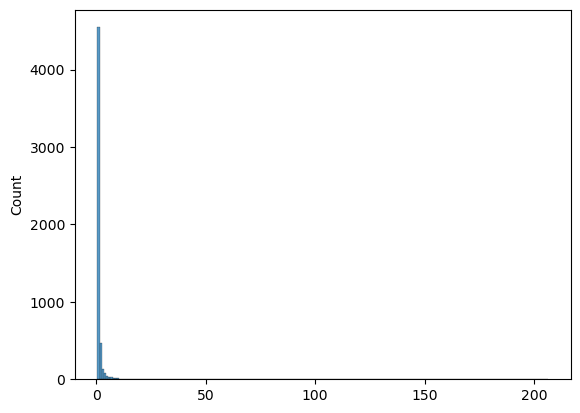

In [36]:
sns.histplot(cohort_type_counts[cohort_type_counts != 0], discrete=True)

## Prepare regression dataset

In [37]:
# Retain only frames with labels
idxs = np.where(equiv_dataset.Q != -1)[0]

### Cohort type counts

In [44]:
X = model_representations[idxs]
# X = np.linalg.norm(model_representations[idxs], axis=1, ord=2, keepdims=True)

y_source = np.log(cohort_type_counts)
# y_source = cohort_token_counts

y_source = (y_source - y_source.mean()) / y_source.std()

y = [y_source[label.item()] for label in equiv_dataset.Q[idxs]]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = RidgeCV().fit(X_train, y_train)

In [47]:
model.score(X_test, y_test)

0.1796440690316986

In [48]:
y_pred = model.predict(X_test)
np.corrcoef(y_pred, y_test)

array([[1.        , 0.42757079],
       [0.42757079, 1.        ]])

Text(0, 0.5, 'Predicted cohort size')

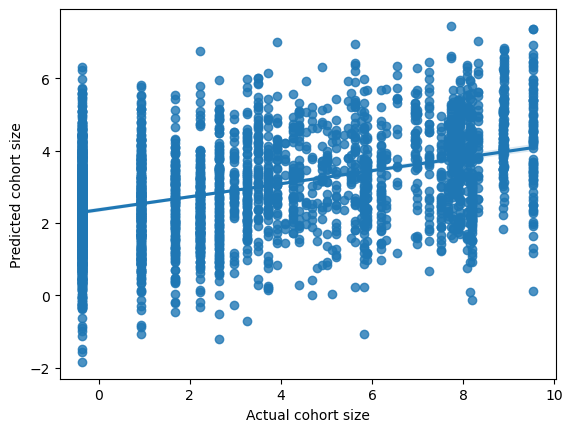

In [49]:
# Scatterplot predicted vs actual cohort type counts
ax = sns.regplot(x=y_test, y=y_pred)
ax.set_xlabel("Actual cohort size")
ax.set_ylabel("Predicted cohort size")

### Cohort token counts

In [ ]:
X = model_representations[idxs]
# X = np.linalg.norm(model_representations[idxs], axis=1, ord=2, keepdims=True)

y_source = cohort_token_counts

y_source = (y_source - y_source.mean()) / y_source.std()

y = [y_source[label.item()] for label in equiv_dataset.Q[idxs]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RidgeCV().fit(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

0.1796440690316986

In [ ]:
y_pred = model.predict(X_test)
np.corrcoef(y_pred, y_test)

array([[1.        , 0.42757079],
       [0.42757079, 1.        ]])

Text(0, 0.5, 'Predicted cohort size')

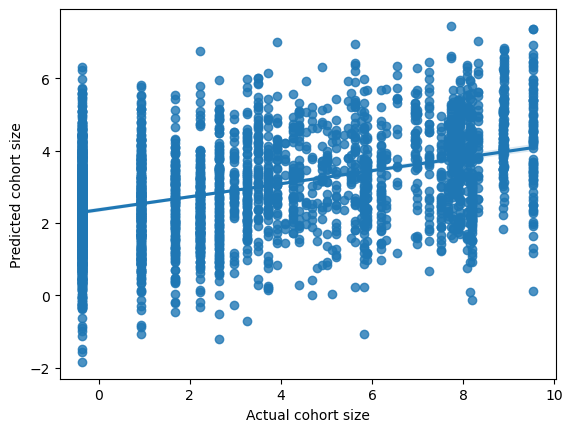

In [ ]:
# Scatterplot predicted vs actual cohort type counts
ax = sns.regplot(x=y_test, y=y_pred)
ax.set_xlabel("Actual cohort size")
ax.set_ylabel("Predicted cohort size")